<a href="https://colab.research.google.com/github/amelierueeck/ULM-25-authorship-profiling/blob/main/src/BERT_probing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code from Polina

In [ ]:
# !pip install spacy ftfy==4.4.3
# !python -m spacy download en

In [1]:
import torch
from transformers import BertTokenizer, BertModel
from transformers import AutoTokenizer, AutoModel
import numpy as np
import pandas as pd
import sys
import os
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device('cpu')

In [3]:
#get data (put files into colab folder)

# load splits
train_df = pd.read_csv("data_train.csv")
val_df   = pd.read_csv("data_val.csv")
test_df  = pd.read_csv("data_test.csv")

print(train_df.head())

                                                text  age  gender
0  Well...kind of an interesting little thingy I ...    0    male
1  Lonliness dominates you. You can hide it well,...    0    male
2  Wearing:New jacket, hoody, dickies, vans, and ...    0  female
3  Well I got into another verbal sparring match ...    3    male
4  Hey everyone.&nbsp; I am in Brugge, Belgium.&n...    2    male


In [4]:
#load pretrained BERT
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_hidden_states=True).to(device)
model.eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [23]:
#get the activations for each layer (length: 13)
def get_activations(texts, out_file, batch_size=16, max_len=256):
    """
    Args:
      texts (list): list of strings
      out_file (str): file to save activations to
    Returns:
      file: npz file with activations for each layer
    """

    first_batch = True
    print("Starting get_activations…", flush=True)

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors="pt", truncation=True,
                           padding=True, max_length=max_len).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            hidden_states = outputs.hidden_states  #tuple of 13 [batch size, sequence length, hidden size 768]

        #take [CLS] token (index 0) from each layer
        batch_layers = [layer_hid[:,0,:].cpu().numpy() for layer_hid in hidden_states]

        # doing this to mitigate RAM issues
        if first_batch:
          np.savez_compressed(out_file, **{f"layer{idx}": arr for idx, arr in enumerate(batch_layers)})
          first_batch = False
          print("First batch done", flush=True)

        else:
          existing = dict(np.load(out_file))
          updated = {f"layer{idx}": np.concatenate([existing[f"layer{idx}"], arr], axis=0) for idx, arr in enumerate(batch_layers)}
          np.savez_compressed(out_file, **updated)
          print(f"Batch {i/16} out of {(1000+16-1)//16} done", flush=True)

    print(f"Saved activations to {out_file}")
    return out_file

In [11]:
def get_layer(split, idx):
  """Get the layer at idx in the given split (test/val/train)"""
  data = np.load(f"{split}_layers.npz")
  return data[f"layer{idx}"]

In [16]:
#define probing function

def train_probe(X_train, y_train, X_val, y_val):
    clf = LogisticRegression(max_iter=5000, class_weight="balanced", multi_class="auto")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    return accuracy_score(y_val, y_pred), clf

**Looking at a subset of the data**

In [12]:
train_subset = train_df["text"].tolist()[:1000]

In [18]:
val_subset = val_df["text"].tolist()[:1000]

In [13]:
get_activations(train_subset, "train_subset_layers.npz")

Starting get_activations…
First batch done
Batch 16 done
Batch 32 done
Batch 48 done
Batch 64 done
Batch 80 done
Batch 96 done
Batch 112 done
Batch 128 done
Batch 144 done
Batch 160 done
Batch 176 done
Batch 192 done
Batch 208 done
Batch 224 done
Batch 240 done
Batch 256 done
Batch 272 done
Batch 288 done
Batch 304 done
Batch 320 done
Batch 336 done
Batch 352 done
Batch 368 done
Batch 384 done
Batch 400 done
Batch 416 done
Batch 432 done
Batch 448 done
Batch 464 done
Batch 480 done
Batch 496 done
Batch 512 done
Batch 528 done
Batch 544 done
Batch 560 done
Batch 576 done
Batch 592 done
Batch 608 done
Batch 624 done
Batch 640 done
Batch 656 done
Batch 672 done
Batch 688 done
Batch 704 done
Batch 720 done
Batch 736 done
Batch 752 done
Batch 768 done
Batch 784 done
Batch 800 done
Batch 816 done
Batch 832 done
Batch 848 done
Batch 864 done
Batch 880 done
Batch 896 done
Batch 912 done
Batch 928 done
Batch 944 done
Batch 960 done
Batch 976 done
Batch 992 done
Saved activations to train_subset

'train_subset_layers.npz'

In [24]:
get_activations(val_subset, "val_subset_layers.npz")

Starting get_activations…
First batch done
Batch 1.0 out of 63 done
Batch 2.0 out of 63 done
Batch 3.0 out of 63 done
Batch 4.0 out of 63 done
Batch 5.0 out of 63 done
Batch 6.0 out of 63 done
Batch 7.0 out of 63 done
Batch 8.0 out of 63 done
Batch 9.0 out of 63 done
Batch 10.0 out of 63 done
Batch 11.0 out of 63 done
Batch 12.0 out of 63 done
Batch 13.0 out of 63 done
Batch 14.0 out of 63 done
Batch 15.0 out of 63 done
Batch 16.0 out of 63 done
Batch 17.0 out of 63 done
Batch 18.0 out of 63 done
Batch 19.0 out of 63 done
Batch 20.0 out of 63 done
Batch 21.0 out of 63 done
Batch 22.0 out of 63 done
Batch 23.0 out of 63 done
Batch 24.0 out of 63 done
Batch 25.0 out of 63 done
Batch 26.0 out of 63 done
Batch 27.0 out of 63 done
Batch 28.0 out of 63 done
Batch 29.0 out of 63 done
Batch 30.0 out of 63 done
Batch 31.0 out of 63 done
Batch 32.0 out of 63 done
Batch 33.0 out of 63 done
Batch 34.0 out of 63 done
Batch 35.0 out of 63 done
Batch 36.0 out of 63 done
Batch 37.0 out of 63 done
Batc

'val_subset_layers.npz'

In [25]:
y_train_subset_gender = train_df["gender"].values[:1000]
y_train_subset_age    = train_df["age"].values[:1000]

In [26]:
y_val_subset_gender = train_df["gender"].values[:1000]
y_val_subset_age    = train_df["age"].values[:1000]

In [27]:
#run probes for gender:

results_subset_gender = []
for layer_idx in range(13):
    acc, _ = train_probe(
        get_layer("train_subset", layer_idx), y_train_subset_gender,
        get_layer("val_subset", layer_idx), y_val_subset_gender
    )
    results_subset_gender.append(acc)
    print(f"[Gender] Layer {layer_idx}: probe accuracy = {acc:.3f}")

[Gender] Layer 0: probe accuracy = 0.486


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Gender] Layer 1: probe accuracy = 0.530


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Gender] Layer 2: probe accuracy = 0.532


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Gender] Layer 3: probe accuracy = 0.531


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Gender] Layer 4: probe accuracy = 0.526


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Gender] Layer 5: probe accuracy = 0.526


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Gender] Layer 6: probe accuracy = 0.536


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Gender] Layer 7: probe accuracy = 0.502


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Gender] Layer 8: probe accuracy = 0.503


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Gender] Layer 9: probe accuracy = 0.530


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Gender] Layer 10: probe accuracy = 0.505


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Gender] Layer 11: probe accuracy = 0.508


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Gender] Layer 12: probe accuracy = 0.489


In [28]:
results_subset_age = []
for layer_idx in range(13):
    acc, _ = train_probe(
        get_layer("train_subset", layer_idx), y_train_subset_age,
        get_layer("val_subset", layer_idx), y_train_subset_age
    )
    results_subset_age.append(acc)
    print(f"[Age] Layer {layer_idx}: probe accuracy = {acc:.3f}")

[Age] Layer 0: probe accuracy = 0.327


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Age] Layer 1: probe accuracy = 0.191


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Age] Layer 2: probe accuracy = 0.203


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Age] Layer 3: probe accuracy = 0.192


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Age] Layer 4: probe accuracy = 0.223


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Age] Layer 5: probe accuracy = 0.246


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Age] Layer 6: probe accuracy = 0.270


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Age] Layer 7: probe accuracy = 0.290


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Age] Layer 8: probe accuracy = 0.285


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Age] Layer 9: probe accuracy = 0.301


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Age] Layer 10: probe accuracy = 0.296


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Age] Layer 11: probe accuracy = 0.293


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Age] Layer 12: probe accuracy = 0.265


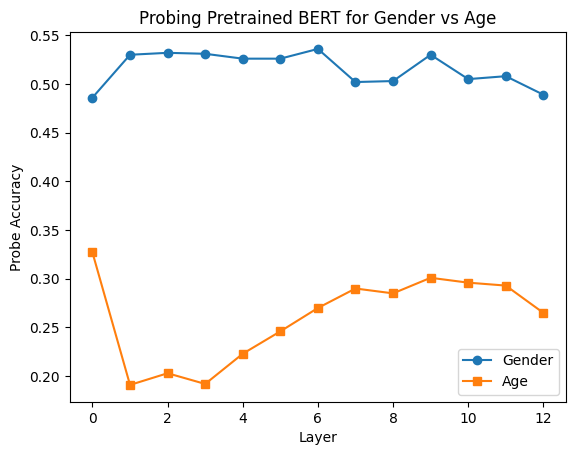

In [29]:
import matplotlib.pyplot as plt

plt.plot(range(13), results_subset_gender, marker="o", label="Gender")
plt.plot(range(13), results_subset_age, marker="s", label="Age")
plt.xlabel("Layer")
plt.ylabel("Probe Accuracy")
plt.title("Probing Pretrained BERT for Gender vs Age")
plt.legend()
plt.show()

**Full datasets**

In [ ]:
get_activations(train_df["text"].tolist(), "train_layers.npz")
get_activations(val_df["text"].tolist(), "val_layers.npz")
get_activations(test_df["text"].tolist(), "test_layers.npz")

In [ ]:
#gender:
y_train_gender = train_df["gender"].values
y_val_gender   = val_df["gender"].values
y_test_gender  = test_df["gender"].values

In [ ]:
#age:
y_train_age = train_df["age"].values
y_val_age   = val_df["age"].values
y_test_age  = test_df["age"].values

In [ ]:
#run probes for gender:

results_gender = []
for layer_idx in range(13):
    acc, _ = train_probe(
        get_layer("train", layer_idx), y_train_gender,
        get_layer("test", layer_idx), y_test_gender
    )
    results_gender.append(acc)
    print(f"[Gender] Layer {layer_idx}: probe accuracy = {acc:.3f}")

In [ ]:
results_age = []
for layer_idx in range(13):
    acc, _ = train_probe(
        get_layer("train", layer_idx), y_train_age,
        get_layer("test", layer_idx), y_test_age
    )
    results_age.append(acc)
    print(f"[Age] Layer {layer_idx}: probe accuracy = {acc:.3f}")

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(13), results_gender, marker="o", label="Gender")
plt.plot(range(13), results_age, marker="s", label="Age")
plt.xlabel("Layer")
plt.ylabel("Probe Accuracy")
plt.title("Probing Pretrained BERT for Gender vs Age")
plt.legend()
plt.show()

**Simple linear classifier**

In [ ]:
class Classifier(torch.nn.Module):

  def __init__(self, input_dim, output_dim):
    super(Classifier, self).__init__()
    self.linear = torch.nn.Linear(input_dim, output_dim)

  def forward(self, input):
    return self.linear(input)

def build_classifier(emb_dim, num_labels, device):
  classifier = Classifier(emb_dim, num_lables).to(device)
  criterion = torch.nn.CrossEntropyLoss().to(device)
  optimizer = torch.optim.Adam(classifier.paramters())

  return classifier, criterion, optimizer